<a href="https://colab.research.google.com/github/DoItSon/playdata/blob/main/%EC%98%A4%EC%9D%BCbase_%EC%A0%84%EC%B2%98%EB%A6%AC(%EC%A0%95%EB%A6%AC%EB%B3%B8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

데이콘 베이스 라인 지금 전처리 = 0.5763416859

In [454]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import random

import warnings
warnings.filterwarnings(action='ignore') 

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [455]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [456]:
DATA_PATH = "/content/drive/MyDrive/"

In [457]:
train = pd.read_csv(f'{DATA_PATH}train.csv')
test = pd.read_csv(f'{DATA_PATH}test.csv')

In [458]:
train.isnull().sum()

ID                         0
COMPONENT_ARBITRARY        0
ANONYMOUS_1                0
YEAR                       0
SAMPLE_TRANSFER_DAY        0
ANONYMOUS_2                0
AG                         0
AL                         0
B                          0
BA                         0
BE                         0
CA                         0
CD                      1394
CO                         0
CR                         0
CU                         0
FH2O                   10205
FNOX                   10205
FOPTIMETHGLY           10205
FOXID                  10205
FSO4                   10205
FTBN                   10205
FE                         0
FUEL                   10205
H2O                        0
K                       2299
LI                         0
MG                         0
MN                         0
MO                         0
NA                         0
NI                         0
P                          0
PB                         0
PQINDEX       

In [459]:
cols = train.columns

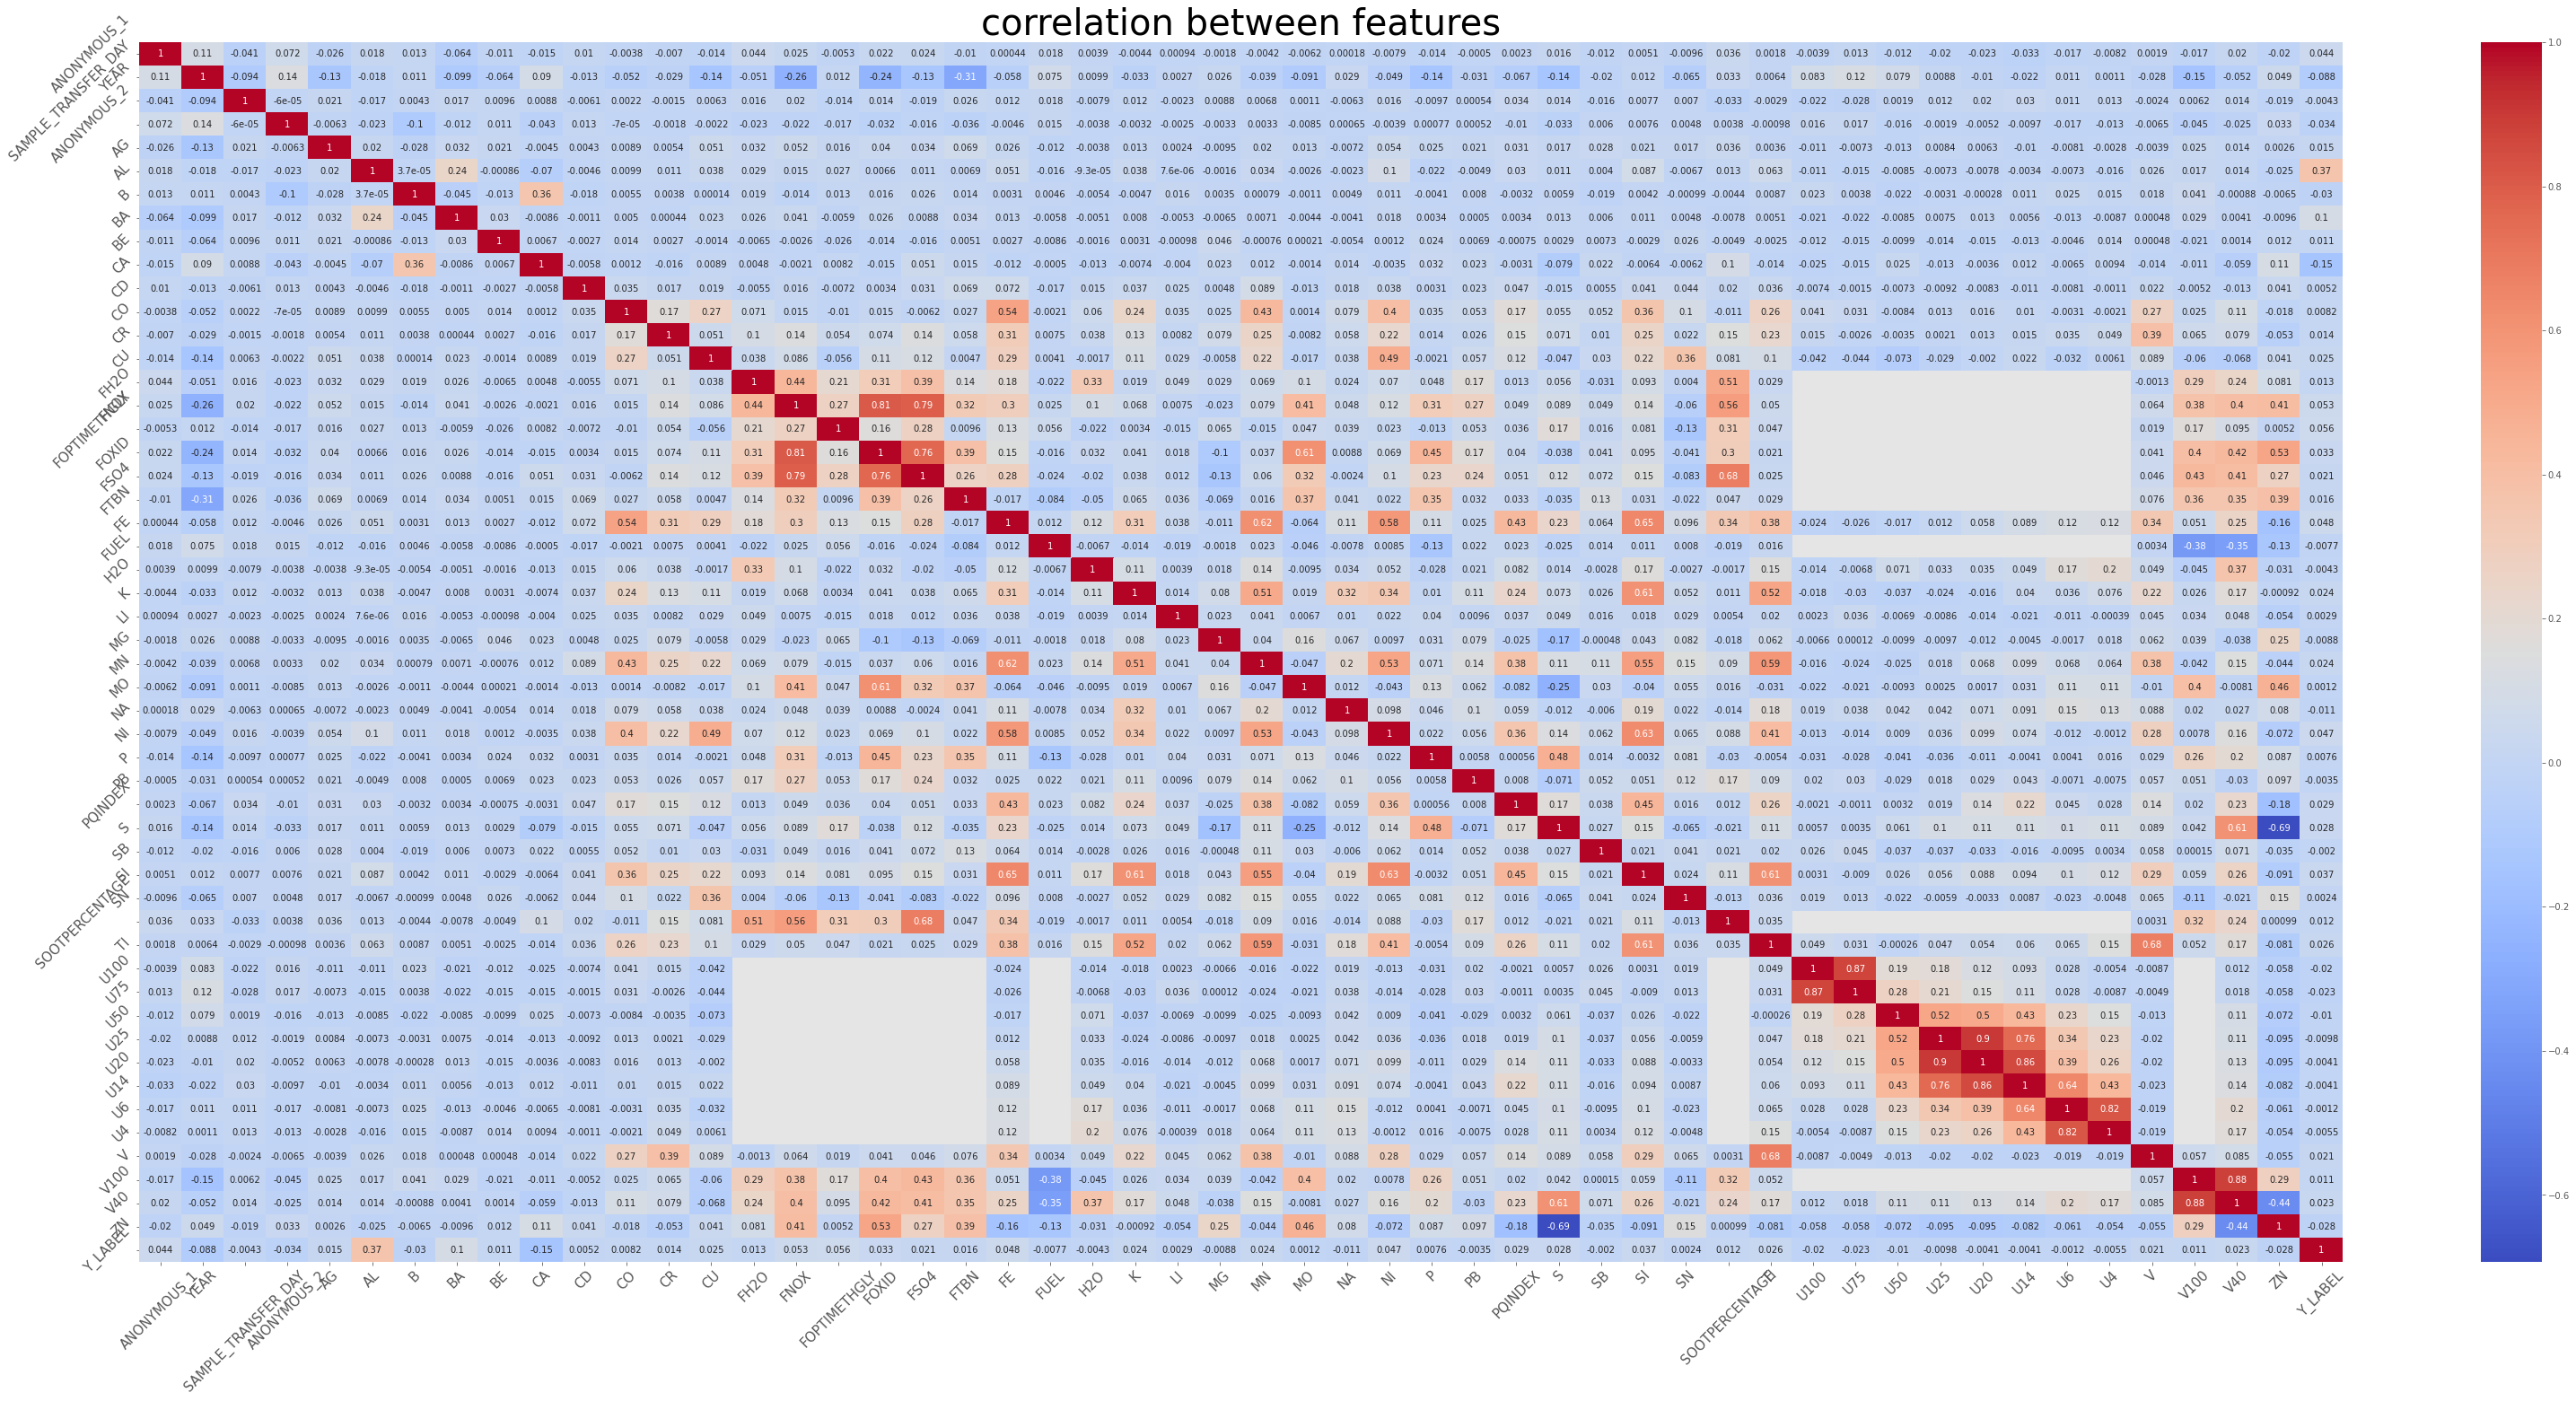

In [460]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

plt.figure(figsize=(55,25))

heat_table = train[cols].corr()
heatmap_ax = sns.heatmap(heat_table, annot=True,cmap='coolwarm')

heatmap_ax.set_xticklabels(heatmap_ax.get_xticklabels(), fontsize=15, rotation=45)
heatmap_ax.set_yticklabels(heatmap_ax.get_yticklabels(), fontsize=15, rotation=45)
plt.title('correlation between features', fontsize=40)
plt.show()

## 상관관계 해석
- Y_LABEL은 AL (0.37) 
- AL은 BA (0.24)
- 추후에 AL과 BA을 곱해서 피처 추가 해보기!

# 데이터 해석

In [461]:
train.sort_values(by=["COMPONENT_ARBITRARY"])

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
7047,TRAIN_07047,COMPONENT1,1712,2014,6,200,0,5,7,2,...,NaN,NaN,NaN,NaN,NaN,0,13.3,92.8,1228,0
3262,TRAIN_03262,COMPONENT1,1373,2022,2,402,0,8,62,0,...,NaN,NaN,NaN,NaN,NaN,0,12.8,97.6,813,0
8734,TRAIN_08734,COMPONENT1,9526,2018,6,375,0,2,7,0,...,NaN,NaN,NaN,NaN,NaN,0,13.8,98.5,1036,0
8733,TRAIN_08733,COMPONENT1,2611,2009,7,200,0,3,30,0,...,NaN,NaN,NaN,NaN,NaN,0,14.1,106.7,1465,0
8730,TRAIN_08730,COMPONENT1,1715,2022,1,469,0,3,9,0,...,NaN,NaN,NaN,NaN,NaN,0,13.8,105.4,1086,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12430,TRAIN_12430,COMPONENT4,2494,2014,7,200,0,2,6,3,...,NaN,NaN,NaN,NaN,NaN,0,NaN,38.4,9,0
10232,TRAIN_10232,COMPONENT4,1345,2012,2,200,0,7,145,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,75.9,1156,0
11339,TRAIN_11339,COMPONENT4,1156,2013,4,356,0,2,66,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,67.8,826,0
11332,TRAIN_11332,COMPONENT4,5550,2015,6,200,0,0,7,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,68.2,1410,0



- COMPONENT_ARBITRARY를 기준으로 정렬해봤을 때 COMPONENT1의 결측치가 가장 적었다.
- 그래서 COMPONENT1을 이용하여 결측치를 채우기로 결정!

## ANONYMOUS_1와 ANONYMOUS_2, YEAR와 SAMPLE_TRANSFER_DAY, COMPONENT_ARBITRARY를 이용하여 전처리 하기!

In [462]:
# COMPONENT_ARBITRARY, ANONYMOUS_1, YEAR, SAMPLE_TRANSFER_DAY, ANONYMOUS_2

# 결측치 채워 넣기 전

In [463]:
def show(df,col):
    fig,ax = plt.subplots()
    ax.bar(df[col].value_counts().index,df[col].value_counts())
    plt.show()
    print(df[col].value_counts())

In [464]:
fill_mean_func = lambda x: x.fillna(x.mean())
fill_median_func = lambda x: x.fillna(x.median())

In [465]:
train.groupby(["V40"]).mean()

,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,CA,...,U50,U25,U20,U14,U6,U4,V,V100,ZN,Y_LABEL
V40,,,,,,,,,,,,,,,,,,,,,
2.9,1175.0,2010.0,7.0,375.0,0.0,3.0,3.0,3.0,0.0,2894.0,...,0.0,343.0,1046.0,2813.0,17853.0,26417.0,0.0,NaN,2.0,0.0
3.4,2255.0,2014.5,4.5,200.0,0.0,3.5,239.5,0.0,0.0,1814.0,...,0.0,7.0,10.5,104.0,3785.0,16780.0,0.0,NaN,2.0,0.0
22.8,7790.0,2016.0,5.0,200.0,0.0,2.0,13.0,0.0,0.0,153.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,5.2,671.0,0.0
28.1,1000.0,2014.0,7.0,200.0,0.0,8.0,77.0,0.0,0.0,3008.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,190.0,0.0
28.6,6427.0,2009.0,9.0,200.0,0.0,3.0,331.0,0.0,0.0,2815.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,307.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440.0,1410.0,2014.0,4.0,200.0,0.0,7.0,1.0,2.0,0.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,34.0,0.0
528.9,1940.0,2018.0,4.0,550.0,0.0,2.0,6.0,2.0,0.0,3190.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,26.0,0.0
577.9,2087.0,2014.0,5.0,200.0,0.0,2.0,128.0,0.0,0.0,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,29.0,0.0


### "ANONYMOUS_2", "ANONYMOUS_1"와 "YEAR", "COMPONENT_ARBITRARY"로 분류

In [466]:
zx = train.groupby(["YEAR","COMPONENT_ARBITRARY"]).apply(fill_mean_func)

In [467]:
zx

ID COMPONENT_ARBITRARY  ANONYMOUS_1  \
YEAR COMPONENT_ARBITRARY                                                       
2007 COMPONENT1          237    TRAIN_00237          COMPONENT1         1524   
                         394    TRAIN_00394          COMPONENT1         1350   
                         460    TRAIN_00460          COMPONENT1         2034   
                         735    TRAIN_00735          COMPONENT1         1352   
                         832    TRAIN_00832          COMPONENT1         2034   
...                                     ...                 ...          ...   
2022 COMPONENT4          11980  TRAIN_11980          COMPONENT4         1388   
                         12715  TRAIN_12715          COMPONENT4         4787   
                         13451  TRAIN_13451          COMPONENT4         2420   
                         13656  TRAIN_13656          COMPONENT4         2295   
                         13902  TRAIN_13902          COMPONENT4         1386   

                                YEAR  SAMPLE_TRANSFER_DAY  ANONYMOUS_2  AG  \
YEAR COMPONENT_ARBITRARY                                                     
2007 COMPONENT1          237    2007                    4          200   0   
                         394    2007                    8          550   0   
                         460    2007                    6          550   0   
                         735    2007                    6          550   0   
                         832    2007                    6          550   0   
...                              ...                  ...          ...  ..   
2022 COMPONENT4          11980  2022                    2          588   0   
                         12715  2022                    1         1013   0   
                         13451  2022                    2          564   0   
                         13656  2022                    4          643   0   
                         13902  2022                    5          586   0   

                                AL    B  BA  ...  U25  U20  U14  U6  U4  V  \
YEAR COMPONENT_ARBITRARY                     ...                             
2007 COMPONENT1          237     5  116   0  ...  NaN  NaN  NaN NaN NaN  0   
                         394     2    6   3  ...  NaN  NaN  NaN NaN NaN  0   
                         460     1    1   1  ...  NaN  NaN  NaN NaN NaN  0   
                         735     2   93   4  ...  NaN  NaN  NaN NaN NaN  0   
                         832     3    0   1  ...  NaN  NaN  NaN NaN NaN  0   
...                             ..  ...  ..  ...  ...  ...  ...  ..  .. ..   
2022 COMPONENT4          11980   1    1   0  ...  NaN  NaN  NaN NaN NaN  0   
                         12715   2   13   0  ...  NaN  NaN  NaN NaN NaN  0   
                         13451   3   77   0  ...  NaN  NaN  NaN NaN NaN  0   
                         13656   1   11   0  ...  NaN  NaN  NaN NaN NaN  0   
                         13902   1    0   0  ...  NaN  NaN  NaN NaN NaN  0   

                                    V100    V40    ZN  Y_LABEL  
YEAR COMPONENT_ARBITRARY                                        
2007 COMPONENT1          237    12.80000   95.7  1384        0  
                         394    12.90000  100.2  1390        1  
                         460    13.40000   98.1  1099        0  
                         735    13.40000   99.3  1018        0  
                         832    13.71194  118.9  1296        0  
...                                  ...    ...   ...      ...  
2022 COMPONENT4          11980       NaN   58.8  1058        0  
                         12715       NaN   77.1  1157        0  
                         13451       NaN   74.0   920        0  
                         13656       NaN   68.0   845        0  
                         13902       NaN   58.9  1136        0  

[14095 rows x 54 columns]

In [468]:
zx = train.groupby(["SAMPLE_TRANSFER_DAY","COMPONENT_ARBITRARY"]).apply(fill_mean_func)
# zx = train.groupby(["SAMPLE_TRANSFER_DAY","YEAR"]).apply(fill_mean_func)
# zx = train.groupby(["SAMPLE_TRANSFER_DAY","YEAR"]).apply(fill_mean_func)

In [469]:
xc = zx.groupby(["ANONYMOUS_2","YEAR"]).apply(fill_mean_func)
# xc = zx.groupby(["ANONYMOUS_2","ANONYMOUS_1"]).apply(fill_mean_func)
# xc = zx.groupby(["ANONYMOUS_1","COMPONENT_ARBITRARY"]).apply(fill_mean_func)
# xc = zx.groupby(["ANONYMOUS_2","COMPONENT_ARBITRARY"]).apply(fill_mean_func)
xc

ID  \
SAMPLE_TRANSFER_DAY COMPONENT_ARBITRARY                      
0                   COMPONENT1          1752   TRAIN_01752   
                                        5481   TRAIN_05481   
                                        6858   TRAIN_06858   
                                        7634   TRAIN_07634   
                                        10143  TRAIN_10143   
...                                                    ...   
203                 COMPONENT1          9331   TRAIN_09331   
216                 COMPONENT3          10422  TRAIN_10422   
245                 COMPONENT3          4111   TRAIN_04111   
246                 COMPONENT3          11857  TRAIN_11857   
368                 COMPONENT1          5978   TRAIN_05978   

                                              COMPONENT_ARBITRARY  \
SAMPLE_TRANSFER_DAY COMPONENT_ARBITRARY                             
0                   COMPONENT1          1752           COMPONENT1   
                                        5481           COMPONENT1   
                                        6858           COMPONENT1   
                                        7634           COMPONENT1   
                                        10143          COMPONENT1   
...                                                           ...   
203                 COMPONENT1          9331           COMPONENT1   
216                 COMPONENT3          10422          COMPONENT3   
245                 COMPONENT3          4111           COMPONENT3   
246                 COMPONENT3          11857          COMPONENT3   
368                 COMPONENT1          5978           COMPONENT1   

                                               ANONYMOUS_1  YEAR  \
SAMPLE_TRANSFER_DAY COMPONENT_ARBITRARY                            
0                   COMPONENT1          1752          4376  2020   
                                        5481          1157  2021   
                                        6858          2118  2010   
                                        7634          3511  2021   
                                        10143         2701  2019   
...                                                    ...   ...   
203                 COMPONENT1          9331          1000  2009   
216                 COMPONENT3          10422         3750  2015   
245                 COMPONENT3          4111          4093  2015   
246                 COMPONENT3          11857         4093  2015   
368                 COMPONENT1          5978          8242  2015   

                                               SAMPLE_TRANSFER_DAY  \
SAMPLE_TRANSFER_DAY COMPONENT_ARBITRARY                              
0                   COMPONENT1          1752                     0   
                                        5481                     0   
                                        6858                     0   
                                        7634                     0   
                                        10143                    0   
...                                                            ...   
203                 COMPONENT1          9331                   203   
216                 COMPONENT3          10422                  216   
245                 COMPONENT3          4111                   245   
246                 COMPONENT3          11857                  246   
368                 COMPONENT1          5978                   368   

                                               ANONYMOUS_2  AG  AL    B  BA  \
SAMPLE_TRANSFER_DAY COMPONENT_ARBITRARY                                       
0                   COMPONENT1          1752           417   0   3    5   0   
                                        5481           357   0   3  178   0   
                                        6858           200   0   3  180   0   
                                        7634           200   0   0    0   0   
                                        10143          200   0   5  122   0   
..

In [470]:
feat = pd.DataFrame(train["ID"].unique(),columns = ["ID"])
feat

,ID
0,TRAIN_00000
1,TRAIN_00001
2,TRAIN_00002
3,TRAIN_00003
4,TRAIN_00004
...,...
14090,TRAIN_14090
14091,TRAIN_14091
14092,TRAIN_14092
14093,TRAIN_14093


In [471]:
features = feat.merge(xc,how="left",on="ID")
train = features

In [472]:
xc1 = train.groupby(["AL","YEAR"]).apply(fill_mean_func)
xc1

ID COMPONENT_ARBITRARY  ANONYMOUS_1  YEAR  \
AL   YEAR                                                             
0    2007 2179   TRAIN_02179          COMPONENT3         1563  2007   
          2880   TRAIN_02880          COMPONENT1         2071  2007   
          3919   TRAIN_03919          COMPONENT3         1318  2007   
          7474   TRAIN_07474          COMPONENT1         1781  2007   
          8043   TRAIN_08043          COMPONENT3         1354  2007   
...                      ...                 ...          ...   ...   
1837 2011 13925  TRAIN_13925          COMPONENT2         3088  2011   
2032 2014 6819   TRAIN_06819          COMPONENT3         3519  2014   
2151 2010 9512   TRAIN_09512          COMPONENT2         3449  2010   
2878 2010 5546   TRAIN_05546          COMPONENT2         3449  2010   
4630 2014 762    TRAIN_00762          COMPONENT2         3096  2014   

                 SAMPLE_TRANSFER_DAY  ANONYMOUS_2  AG    AL    B  BA  ...  \
AL   YEAR                                                             ...   
0    2007 2179                     6          200   0     0    4   0  ...   
          2880                     3          200   0     0    2   1  ...   
          3919                    12          518   0     0   22   1  ...   
          7474                     6          200   0     0    6   0  ...   
          8043                     2          554   0     0   17   1  ...   
...                              ...          ...  ..   ...  ...  ..  ...   
1837 2011 13925                    4          200   0  1837  129  13  ...   
2032 2014 6819                     2          200   0  2032    1  26  ...   
2151 2010 9512                     3          200   0  2151   32  16  ...   
2878 2010 5546                     3          200   0  2878   54  23  ...   
4630 2014 762                      4          200   0  4630   33  46  ...   

                       U25        U20         U14           U6            U4  \
AL   YEAR                                                                      
0    2007 2179   31.466667  53.733333  609.970010  8871.885476  24405.242925   
          2880   31.466667  53.733333  609.970010  8871.885476  24405.242925   
          3919   67.222222  91.444444  670.641675  9220.737896  23827.035771   
          7474   31.466667  53.733333  609.970010  8871.885476  24405.242925   
          8043   67.222222  91.444444  670.641675  9220.737896  23827.035771   
...                    ...        ...         ...          ...           ...   
1837 2011 13925  16.000000  27.000000   90.000000  1434.000000   3615.000000   
2032 2014 6819   28.328358  48.845771  180.144224  3959.977286  13717.972987   
2151 2010 9512    1.000000   2.000000   21.000000   520.000000  12148.000000   
2878 2010 5546   21.000000  31.000000  189.030973  4299.429204  18023.915929   
4630 2014 762     9.000000  17.000000  152.000000  2518.000000   4662.000000   

                 V       V100    V40    ZN  Y_LABEL  
AL   YEAR                                            
0    2007 2179   0  14.412178  136.2    49        0  
          2880   0  15.900000  129.0  1280        0  
          3919   0  14.856089  146.3   148        0  
          7474   0  14.200000  133.9  1243        0  
          8043   0  14.856089  189.6    44        0  
...             ..        ...    ...   ...      ...  
1837 2011 13925  0  13.639260   51.3   576        1  
2032 2014 6819   0  13.585227  156.6    17        1  
2151 2010 9512   0  13.907224   46.8   714        1  
2878 2010 5546   0  13.907224   50.0   578        1  
4630 2014 762    0  13.585227   63.1   436        1  

[14095 rows x 54 columns]

In [473]:
xc1.isnull().sum()

ID                      0
COMPONENT_ARBITRARY     0
ANONYMOUS_1             0
YEAR                    0
SAMPLE_TRANSFER_DAY     0
ANONYMOUS_2             0
AG                      0
AL                      0
B                       0
BA                      0
BE                      0
CA                      0
CD                      0
CO                      0
CR                      0
CU                      0
FH2O                   64
FNOX                   64
FOPTIMETHGLY           64
FOXID                  64
FSO4                   64
FTBN                   64
FE                      0
FUEL                   64
H2O                     0
K                       0
LI                      0
MG                      0
MN                      0
MO                      0
NA                      0
NI                      0
P                       0
PB                      0
PQINDEX                 0
S                       0
SB                      0
SI                      0
SN          

In [434]:
train

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
0,TRAIN_00000,COMPONENT3,1486,2011,7,200,0,3,93,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,154.0,75,0
1,TRAIN_00001,COMPONENT2,1350,2021,51,375,0,2,19,0,...,2.0,4.0,6.0,216.0,1454.0,0,NaN,44.0,652,0
2,TRAIN_00002,COMPONENT2,2415,2015,2,200,0,110,1,1,...,0.0,3.0,39.0,11261.0,41081.0,0,NaN,72.6,412,1
3,TRAIN_00003,COMPONENT3,7389,2010,2,200,0,8,3,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,133.3,7,0
4,TRAIN_00004,COMPONENT3,3954,2015,4,200,0,1,157,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,133.1,128,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,TRAIN_14090,COMPONENT3,1616,2014,8,200,0,2,201,1,...,NaN,NaN,NaN,NaN,NaN,0,NaN,135.4,16,0
14091,TRAIN_14091,COMPONENT1,2784,2013,2,200,0,3,85,0,...,NaN,NaN,NaN,NaN,NaN,0,14.5,117.5,1408,0
14092,TRAIN_14092,COMPONENT3,1788,2008,9,550,0,6,0,1,...,NaN,NaN,NaN,NaN,NaN,0,NaN,54.0,1301,0
14093,TRAIN_14093,COMPONENT2,2498,2009,19,550,0,2,4,0,...,7.0,8.0,100.0,1625.0,18890.0,0,NaN,44.3,652,0


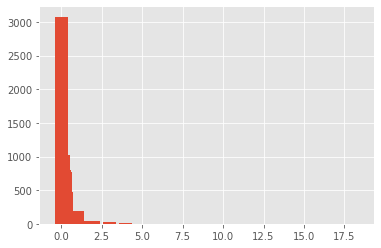

0.000000     3078
0.119403     1019
0.118919      866
0.187919      798
0.181287      766
0.278571      763
0.214286      677
0.135338      652
0.099174      598
0.045455      524
0.333333      479
0.154762      359
0.150000      276
1.000000      185
0.074074      138
0.280000      107
0.066667       86
0.100000       76
0.083333       55
2.000000       49
0.272727       43
1.555556       41
0.090909       35
3.000000       22
0.500000       11
0.250000        8
4.000000        7
1.500000        5
1.666667        3
5.000000        3
10.000000       2
6.000000        2
12.000000       2
18.000000       1
7.000000        1
8.000000        1
11.000000       1
13.000000       1
Name: U100, dtype: int64


In [478]:
show(xc,"U100")  # U25,U20,U14/U6,U4 => 0으로 채우기!
# FNOX는 FOXID,FSO4

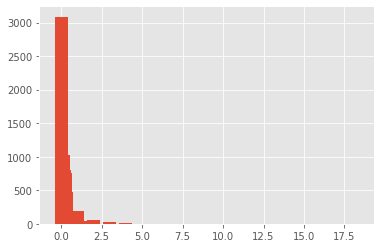

0.000000    3087
0.119403    1019
0.118919     867
0.187919     798
0.181287     766
            ... 
0.092562       1
0.210000       1
0.052083       1
0.081142       1
7.000000       1
Name: U100, Length: 209, dtype: int64


In [479]:
show(xc1,"U100")  # U25,U20,U14/U6,U4 => 0으로 채우기!

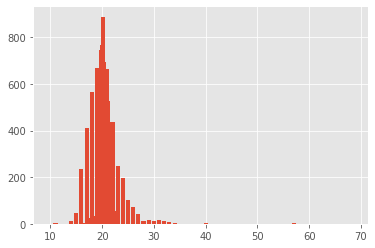

20.204819    888
20.000000    765
19.756579    747
20.384314    692
19.000000    669
            ... 
42.000000      1
25.500000      1
68.000000      1
55.000000      1
24.333333      1
Name: FSO4, Length: 85, dtype: int64


In [480]:
show(xc,"FSO4")

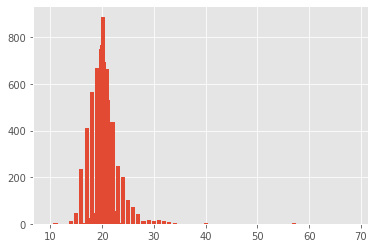

20.204819    888
20.000000    768
19.756579    748
20.384314    692
19.000000    670
            ... 
25.500000      1
19.017834      1
21.916667      1
42.000000      1
36.000000      1
Name: FSO4, Length: 244, dtype: int64


In [481]:
show(xc1,"FSO4")  # U25,U20,U14/U6,U4 => 0으로 채우기

In [482]:
feat = pd.DataFrame(train["ID"].unique(),columns = ["ID"])
feat

,ID
0,TRAIN_00000
1,TRAIN_00001
2,TRAIN_00002
3,TRAIN_00003
4,TRAIN_00004
...,...
14090,TRAIN_14090
14091,TRAIN_14091
14092,TRAIN_14092
14093,TRAIN_14093


In [487]:
features = feat.merge(xc1,how="left",on="ID")
train = features

In [488]:
train

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
0,TRAIN_00000,COMPONENT3,1486,2011,7,200,0,3,93,0,...,25.483221,65.657718,265.222841,5615.019189,18599.617449,0,13.639260,154.0,75,0
1,TRAIN_00001,COMPONENT2,1350,2021,51,375,0,2,19,0,...,2.000000,4.000000,6.000000,216.000000,1454.000000,0,13.300000,44.0,652,0
2,TRAIN_00002,COMPONENT2,2415,2015,2,200,0,110,1,1,...,0.000000,3.000000,39.000000,11261.000000,41081.000000,0,13.613313,72.6,412,1
3,TRAIN_00003,COMPONENT3,7389,2010,2,200,0,8,3,0,...,29.981818,54.309091,198.483886,5428.819382,19571.831588,0,13.907224,133.3,7,0
4,TRAIN_00004,COMPONENT3,3954,2015,4,200,0,1,157,0,...,33.865497,60.409357,279.640746,5935.617038,22551.584953,0,13.613313,133.1,128,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,TRAIN_14090,COMPONENT3,1616,2014,8,200,0,2,201,1,...,28.328358,48.845771,180.144224,3959.977286,13717.972987,0,13.585227,135.4,16,0
14091,TRAIN_14091,COMPONENT1,2784,2013,2,200,0,3,85,0,...,27.491892,44.908108,201.577815,3898.352917,13537.118569,0,14.500000,117.5,1408,0
14092,TRAIN_14092,COMPONENT3,1788,2008,9,550,0,6,0,1,...,12.450000,24.025000,119.545730,2881.378482,16448.336158,0,13.871036,54.0,1301,0
14093,TRAIN_14093,COMPONENT2,2498,2009,19,550,0,2,4,0,...,7.000000,8.000000,100.000000,1625.000000,18890.000000,0,13.437500,44.3,652,0


In [ ]:
# cols = ["FH2O","FNOX","FOPTIMETHGLY","FOXID","FSO4","FTBN","FUEL","SOOTPERCENTAGE","U100","U75","U50","U25","U20","U14","CD","U6","U4","V100"]

In [489]:
train.isnull().sum()

ID                      0
COMPONENT_ARBITRARY     0
ANONYMOUS_1             0
YEAR                    0
SAMPLE_TRANSFER_DAY     0
ANONYMOUS_2             0
AG                      0
AL                      0
B                       0
BA                      0
BE                      0
CA                      0
CD                      0
CO                      0
CR                      0
CU                      0
FH2O                   64
FNOX                   64
FOPTIMETHGLY           64
FOXID                  64
FSO4                   64
FTBN                   64
FE                      0
FUEL                   64
H2O                     0
K                       0
LI                      0
MG                      0
MN                      0
MO                      0
NA                      0
NI                      0
P                       0
PB                      0
PQINDEX                 0
S                       0
SB                      0
SI                      0
SN          

In [ ]:
train

## 해석


In [ ]:
# mode_cols = ["CD"]  # CD는 이상치가 있어서 median 사용!
# for i in mode_cols:
#     mode = train[i].mean()
#     train[i] = train[i].fillna(mode)

In [ ]:
# # V40,V100은 상관관계가 높으므로 0을 넣음!
# mode = train["V40"].median()
# train[i] = train[i].fillna(mode)

In [ ]:
# mode = train["V100"].mean()
# train[i] = train[i].fillna(mode)

In [490]:
train.isnull().sum().sum()

1248

# 결측치 채우기!

In [ ]:
# FNOX, FOXID,FSO4   mean으로 채우기
# U75, U100 0으로 채우기!
# U25, U20,U14, (U14=0.64) 최빈값으로 채우기
# U6는 U4 (mean or median)
# 나머지 결측치는 0으로 채우기!

In [ ]:
mode_cols = ["FNOX", "FOXID","FSO4" ]
for i in mode_cols:
    mode = train[i].median()
    train[i] = train[i].fillna(mode)

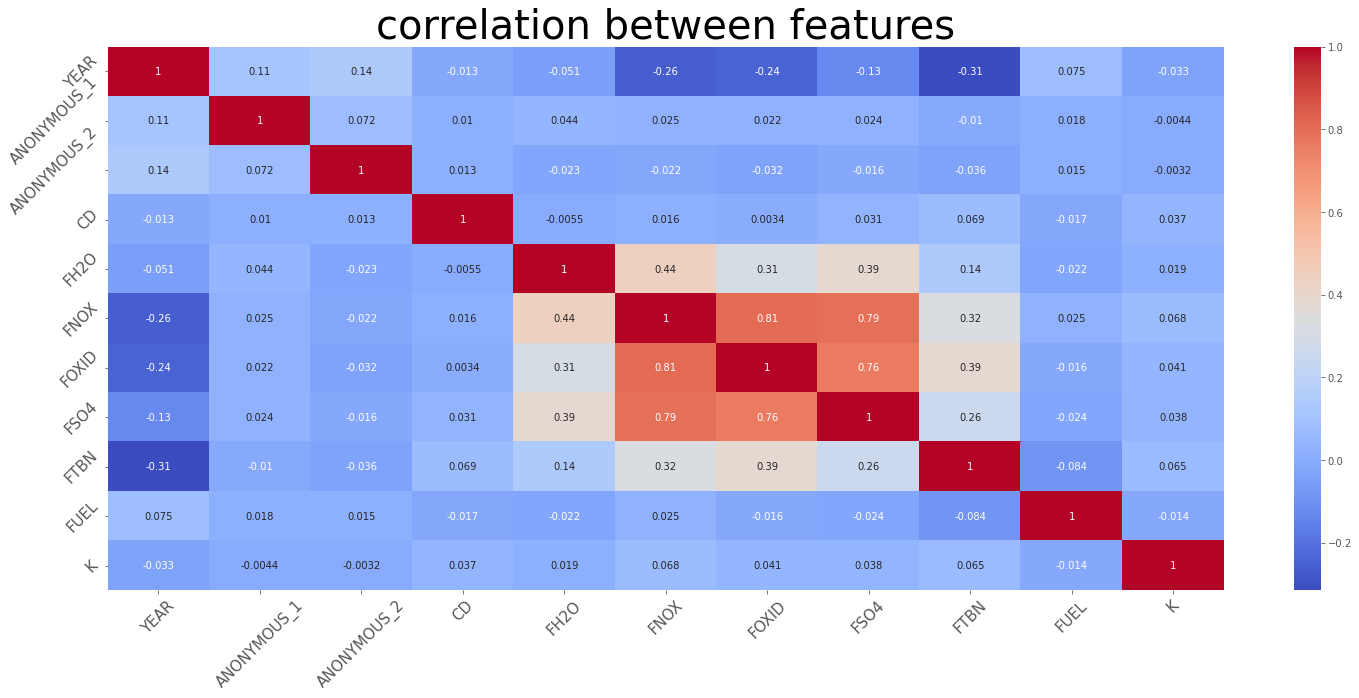

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

plt.figure(figsize=(25,10))

heat_table = train[['CD', 'FH2O', 'FNOX', 'FOXID', 'FSO4', 'FTBN', 'FUEL', 'K']].corr()
heatmap_ax = sns.heatmap(heat_table, annot=True,cmap='coolwarm')

heatmap_ax.set_xticklabels(heatmap_ax.get_xticklabels(), fontsize=15, rotation=45)
heatmap_ax.set_yticklabels(heatmap_ax.get_yticklabels(), fontsize=15, rotation=45)

plt.title('correlation between features', fontsize=40)
plt.show()

In [ ]:
# 떨어진 상관관계 리스트
# cd,ftbn/cd,fuel/cd,k 
# k,ftbm / k,fuel
# fuel,fh2o

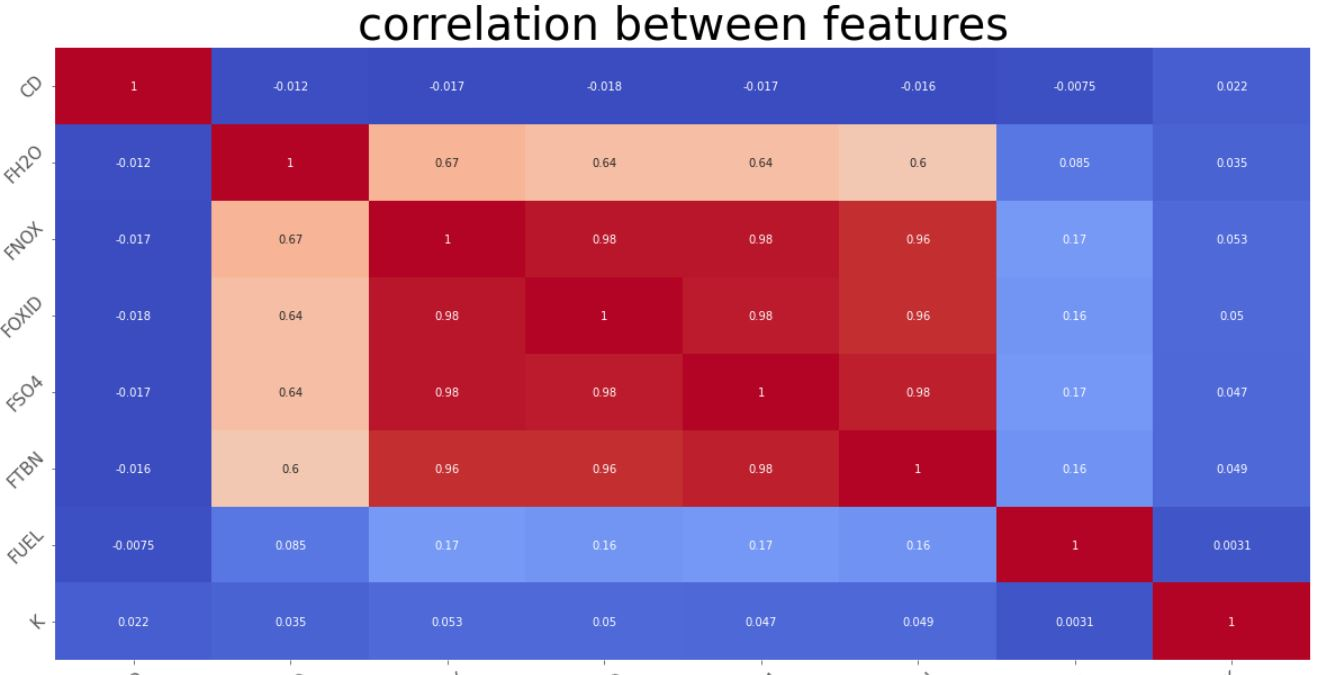

In [ ]:
# median_cols = ["U25","U20","U14","U6","U4"]
# for i in median_cols:
#     mode = train[i].median()
#     train[i] = train[i].fillna(mode)

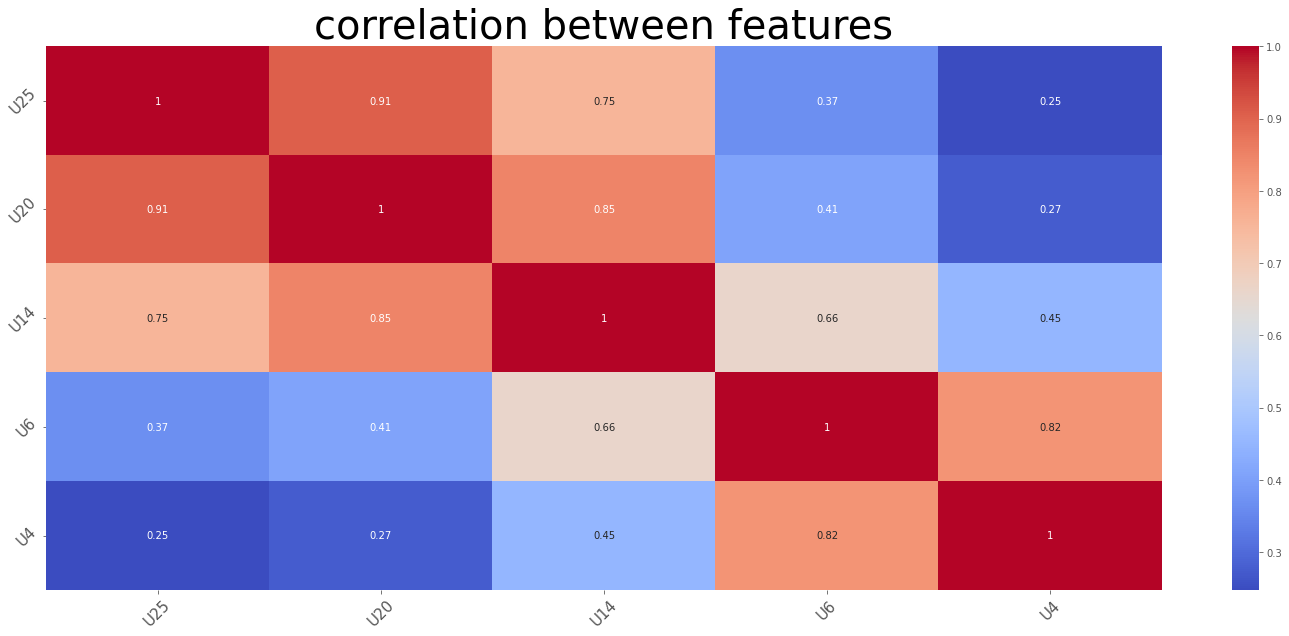

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

plt.figure(figsize=(25,10))

heat_table = train[["U25","U20","U14","U6","U4"]].corr()
heatmap_ax = sns.heatmap(heat_table, annot=True,cmap='coolwarm')

heatmap_ax.set_xticklabels(heatmap_ax.get_xticklabels(), fontsize=15, rotation=45)
heatmap_ax.set_yticklabels(heatmap_ax.get_yticklabels(), fontsize=15, rotation=45)

plt.title('correlation between features', fontsize=40)
plt.show()

In [ ]:
#  "FH2O","FNOX","FOXID","FSO4","FTBN","SOOTPERCENTAGE","U25","U20","U14","U6","U4","V100" 평균으로 채우기

In [ ]:
# 'CD','FOPTIMETHGLY',"FUEL",'K','U100','U75','U50' 는 최빈값 or 0으로 채우기 (정정 중앙값으로 채움)

In [ ]:
# mode_cols = ['CD','FOPTIMETHGLY',"FUEL",'K','U100','U75','U50']
# for i in mode_cols:
#     mode = train[i].mode()[0]
#     train[i] = train[i].fillna(mode)
# 제일 높음!

In [ ]:
train.isnull().sum().sum()

159915

In [ ]:
# mean_cols = ["FH2O","FNOX","FOXID","FSO4","FTBN","SOOTPERCENTAGE","V100"]
# for i in mean_cols:
#     mode = train[i].mean()
#     train[i] = train[i].fillna(mode)

In [ ]:
# median_cols = ["U25","U20","U14","U6","U4"]
# for i in median_cols:
#     mode = train[i].median()
#     train[i] = train[i].fillna(mode)

In [308]:
train.isnull().sum().sum()

96256

In [ ]:
# mask = train["U25"].isin([1654])
# y = train.loc[mask]
# y # 4부터 시작 최빈값으로 채우기 CD, FOPTIMETHGLY,FUEL,K

- 전처리

In [ ]:
# x = train.isnull().sum().reset_index()
# cols = list(x["index"])
# mask = x[0]!=0
# x1 = x.loc[mask]
# cols=list(x1["index"])
# cols

In [ ]:
# from sklearn.impute import SimpleImputer

# for i in cols:
#     imputer = SimpleImputer(strategy="most_frequent")
#     train[i] = imputer.fit_transform(train[[i]])

In [ ]:
# from sklearn.impute import KNNImputer
# for i in cols:
#     imputer = KNNImputer(n_neighbors=13,weights="distance")
#     train[i] = imputer.fit_transform(train[[i]])

In [68]:
CFG = {
    'EPOCHS': 30,
    'LEARNING_RATE':1e-2,
    'BATCH_SIZE':256,
    'SEED':41
}

In [69]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

In [ ]:
train

In [70]:
feat = pd.DataFrame(train["ID"].unique(),columns = ["ID"])
feat

,ID
0,TRAIN_00000
1,TRAIN_00001
2,TRAIN_00002
3,TRAIN_00003
4,TRAIN_00004
...,...
14090,TRAIN_14090
14091,TRAIN_14091
14092,TRAIN_14092
14093,TRAIN_14093


In [71]:
features = feat.merge(xc,how="left",on="ID")

In [72]:
train = features

In [491]:
train = train.fillna(0)
test = test.fillna(0)

In [492]:
categorical_features = ['COMPONENT_ARBITRARY', 'YEAR']
# Inference(실제 진단 환경)에 사용하는 컬럼
test_stage_features = ['COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR' , 'ANONYMOUS_2', 'AG', 'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN']

In [493]:
all_X = train.drop(['ID', 'Y_LABEL'], axis = 1)
all_y = train['Y_LABEL']

test = test.drop(['ID'], axis = 1)

train_X, val_X, train_y, val_y = train_test_split(all_X, all_y, test_size=0.2, random_state=CFG['SEED'], stratify=all_y)
train_X.shape, val_X.shape, train_y.shape, val_y.shape

((11276, 52), (2819, 52), (11276,), (2819,))

In [494]:
def get_values(value):
    return value.values.reshape(-1, 1)

for col in train_X.columns:
    if col not in categorical_features:
        scaler = StandardScaler()
        train_X[col] = scaler.fit_transform(get_values(train_X[col]))
        val_X[col] = scaler.transform(get_values(val_X[col]))
        if col in test.columns:
            test[col] = scaler.transform(get_values(test[col]))

le = LabelEncoder()
for col in categorical_features:    
    train_X[col] = le.fit_transform(train_X[col])
    val_X[col] = le.transform(val_X[col])
    if col in test.columns:
        test[col] = le.transform(test[col])

In [495]:
train_X

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,...,U50,U25,U20,U14,U6,U4,V,V100,V40,ZN
822,2,0.018731,4,-0.051286,-0.356161,-0.150219,-0.119547,-0.186532,-0.225981,-0.042285,...,-0.256033,-0.116794,0.102643,0.078384,0.034450,-0.019596,-0.107095,0.099156,0.678413,-1.097000
6794,1,0.671873,6,-0.475757,-0.356161,-0.150219,-0.141100,-0.633402,-0.225981,-0.042285,...,-0.295992,-0.197521,-0.116622,-0.102141,-0.053416,0.072768,-0.107095,0.103559,-1.211150,-0.081955
12200,2,-0.464419,7,0.033608,-0.356161,-0.150219,-0.097994,-0.603611,1.053536,-0.042285,...,-0.007540,-0.050855,-0.094930,-0.192314,-0.196900,-0.281451,-0.107095,0.049477,0.447358,-0.948227
10326,2,-0.250266,4,-0.221075,0.379399,-0.150219,-0.119547,-0.613541,0.733657,-0.042285,...,-0.256396,-0.162678,0.025546,0.022124,-0.006897,-0.039551,-0.107095,0.112250,1.516479,-1.031088
319,2,-0.246705,9,0.203397,-0.356161,-0.150219,-0.097994,4.450985,-0.225981,-0.042285,...,1.123065,0.397389,0.435544,0.441829,0.362534,0.253894,-0.107095,-0.022374,0.602048,-0.219428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8187,1,0.186587,5,0.542974,-0.356161,-0.150219,-0.130324,-0.524167,-0.225981,-0.042285,...,-0.295992,0.729520,0.635504,1.149923,0.086867,-0.120903,-0.107095,0.124980,-1.283600,0.064935
6763,2,0.727667,9,0.458080,-0.356161,-0.150219,-0.141100,-0.633402,-0.225981,-0.042285,...,1.123065,0.397389,0.435544,0.441829,0.362534,0.253894,-0.107095,-0.022374,0.674497,-0.904914
5944,0,-0.173580,6,-0.305969,-0.356161,-0.150219,-0.033334,0.717138,-0.225981,-0.042285,...,-0.152572,-0.070241,-0.141206,-0.124118,-0.205514,-0.291152,-0.107095,-0.212774,-0.265389,1.409541
9952,2,-0.339062,3,-0.475757,0.001940,-0.150219,-0.108771,-0.603611,-0.225981,-0.042285,...,-0.286912,0.045814,0.183000,0.024839,0.026052,0.112630,-0.107095,0.340212,-0.171401,0.260788


In [496]:
class CustomDataset(Dataset):
    def __init__(self, data_X, data_y, distillation=False):
        super(CustomDataset, self).__init__()
        self.data_X = data_X
        self.data_y = data_y
        self.distillation = distillation
        
    def __len__(self):
        return len(self.data_X)
    
    def __getitem__(self, index):
        if self.distillation:
            # 지식 증류 학습 시
            teacher_X = torch.Tensor(self.data_X.iloc[index])
            student_X = torch.Tensor(self.data_X[test_stage_features].iloc[index])
            y = self.data_y.values[index]
            return teacher_X, student_X, y
        else:
            if self.data_y is None:
                test_X = torch.Tensor(self.data_X.iloc[index])
                return test_X
            else:
                teacher_X = torch.Tensor(self.data_X.iloc[index])
                y = self.data_y.values[index]
                return teacher_X, y


In [497]:
train_dataset = CustomDataset(train_X, train_y, False)
val_dataset = CustomDataset(val_X, val_y, False)

In [498]:
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)

In [499]:
class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=52, out_features=256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Linear(in_features=1024, out_features=256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        output = self.classifier(x)
        return output

In [500]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)

    best_score = 0
    best_model = None
    criterion = nn.BCELoss().to(device)

    for epoch in range(CFG["EPOCHS"]):
        train_loss = []
  
        model.train()
        for X, y in tqdm(train_loader):
            X = X.float().to(device)
            y = y.float().to(device)
            
            optimizer.zero_grad()
            
            y_pred = model(X)
            
            loss = criterion(y_pred, y.reshape(-1, 1))
            loss.backward()
            
            optimizer.step()

            train_loss.append(loss.item())

        val_loss, val_score = validation_teacher(model, val_loader, criterion, device)

        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss) :.5f}] Val Loss : [{np.mean(val_loss) :.5f}] Val F1 Score : [{val_score:.5f}]')

        if scheduler is not None:
            scheduler.step(val_score)
            
        if best_score < val_score:
            best_model = model
            best_score = val_score
        
    return best_model 

In [501]:
def competition_metric(true, pred):
    return f1_score(true, pred, average="macro")

def validation_teacher(model, val_loader, criterion, device):
    model.eval()

    val_loss = []
    pred_labels = []
    true_labels = []
    threshold = 0.35
    
    with torch.no_grad():
        for X, y in tqdm(val_loader):
            X = X.float().to(device)
            y = y.float().to(device)
            
            model_pred = model(X.to(device))
            
            loss = criterion(model_pred, y.reshape(-1, 1))
            val_loss.append(loss.item())      
            
            model_pred = model_pred.squeeze(1).to('cpu')  
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
        val_f1 = competition_metric(true_labels, pred_labels)
    return val_loss, val_f1   

In [ ]:
model = Teacher()
model.eval()
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold_mode='abs',min_lr=1e-8, verbose=True)

teacher_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [0], Train Loss : [0.25922] Val Loss : [0.29930] Val F1 Score : [0.74716]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.19077] Val Loss : [0.31787] Val F1 Score : [0.76474]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.19067] Val Loss : [0.23700] Val F1 Score : [0.76517]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.17482] Val Loss : [0.25265] Val F1 Score : [0.78802]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.18083] Val Loss : [0.28160] Val F1 Score : [0.78674]


  0%|          | 0/45 [00:00<?, ?it/s]

In [ ]:
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=18, out_features=128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(in_features=512, out_features=128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        output = self.classifier(x)
        return output

In [ ]:
def distillation(student_logits, labels, teacher_logits, alpha):
    distillation_loss = nn.BCELoss()(student_logits, teacher_logits)
    student_loss = nn.BCELoss()(student_logits, labels.reshape(-1, 1))
    return alpha * student_loss + (1-alpha) * distillation_loss

In [ ]:
def distill_loss(output, target, teacher_output, loss_fn=distillation, opt=optimizer):
    loss_b = loss_fn(output, target, teacher_output, alpha=0.1)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item()

In [ ]:
def student_train(s_model, t_model, optimizer, train_loader, val_loader, scheduler, device):
    s_model.to(device)
    t_model.to(device)
    
    best_score = 0
    best_model = None

    for epoch in range(CFG["EPOCHS"]):
        train_loss = []
        s_model.train()
        t_model.eval()
        
        for X_t, X_s, y in tqdm(train_loader):
            X_t = X_t.float().to(device)
            X_s = X_s.float().to(device)
            y = y.float().to(device)
            
            optimizer.zero_grad()

            output = s_model(X_s)
            with torch.no_grad():
                teacher_output = t_model(X_t)
                
            loss_b = distill_loss(output, y, teacher_output, loss_fn=distillation, opt=optimizer)

            train_loss.append(loss_b)

        val_loss, val_score = validation_student(s_model, t_model, val_loader, distill_loss, device)
        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss) :.5f}] Val Loss : [{np.mean(val_loss) :.5f}] Val F1 Score : [{val_score:.5f}]')
        
        if scheduler is not None:
            scheduler.step(val_score)
            
        if best_score < val_score:
            best_model = s_model
            best_score = val_score
        
    return best_model


In [ ]:

def validation_student(s_model, t_model, val_loader, criterion, device):
    s_model.eval()
    t_model.eval()

    val_loss = []
    pred_labels = []
    true_labels = []
    threshold = 0.35
    
    with torch.no_grad():
        for X_t, X_s, y in tqdm(val_loader):
            X_t = X_t.float().to(device)
            X_s = X_s.float().to(device)
            y = y.float().to(device)
            
            model_pred = s_model(X_s)
            teacher_output = t_model(X_t)
            
            loss_b = distill_loss(model_pred, y, teacher_output, loss_fn=distillation, opt=None)
            val_loss.append(loss_b)
            
            model_pred = model_pred.squeeze(1).to('cpu')
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
        val_f1 = competition_metric(true_labels, pred_labels)
    return val_loss, val_f1    

In [ ]:
train_dataset = CustomDataset(train_X, train_y, True)
val_dataset = CustomDataset(val_X, val_y, True)

train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)


In [ ]:
student_model = Student()
student_model.eval()
optimizer = torch.optim.AdamW(student_model.parameters(), lr=CFG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold_mode='abs',min_lr=1e-8, verbose=True)

best_student_model = student_train(student_model, teacher_model, optimizer, train_loader, val_loader, scheduler, device)

In [ ]:
def choose_threshold(model, val_loader, device):
    model.to(device)
    model.eval()
    
    thresholds = [0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
    pred_labels = []
    true_labels = []
    
    best_score = 0
    best_thr = None
    with torch.no_grad():
        for _, x_s, y in tqdm(iter(val_loader)):
            x_s = x_s.float().to(device)
            y = y.float().to(device)
            
            model_pred = model(x_s)
            
            model_pred = model_pred.squeeze(1).to('cpu')
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        for threshold in thresholds:
            pred_labels_thr = np.where(np.array(pred_labels) > threshold, 1, 0)
            score_thr = competition_metric(true_labels, pred_labels_thr)
            if best_score < score_thr:
                best_score = score_thr
                best_thr = threshold
    return best_thr, best_score

In [ ]:
best_threshold, best_score = choose_threshold(best_student_model, val_loader, device)
print(f'Best Threshold : [{best_threshold}], Score : [{best_score:.5f}]')
# 0.58403
# [0.57187]
# mean[0.57812]
# 원핫인코딩 = [0.54376]
# lr를 2로 변경 = [0.55327]
# 위에 + standard스케일링 = [0.57166]
# 위에 AdamW = [0.57277] *************
# 에폭 50 = [0.56790]
# line9 + elu = [0.56184]
# line9 + median(결측치) = [0.57021]
# mode = [0.57251]
# mean과 mode =  [0.55979]
# mode + 0 = [0.56870]
# 기존 + GRU = [0.56706]
# 기존 + GRU(ELU) = [0.55696]
# 기존 + LSTM = [0.56892]
# 위에 + 전처리(KNNImputer) = [0.58015]
# 위에 AdamW = [0.57277] + 전처리(KNNImputer) = [0.57171]
# 다시 돌아옴 = [0.57508]
# 결측치 + 다시 돌아옴 = [0.57427]
# 다시 돌아옴 + 내결측치 가설 맞은듯? = [0.57809]
# mask 2개 = [0.56536]
# mask 3개 = [0.58376]
# [0.53884]
# [0.54830]

In [366]:
test_datasets = CustomDataset(test, None, False)
test_loaders = DataLoader(test_datasets, batch_size = CFG['BATCH_SIZE'], shuffle=False)

In [361]:
def inference(model, test_loader, threshold, device):
    model.to(device)
    model.eval()
    
    test_predict = []
    with torch.no_grad():
        for x in tqdm(test_loader):
            x = x.float().to(device)
            model_pred = model(x)

            model_pred = model_pred.squeeze(1).to('cpu')
            test_predict += model_pred
        
    test_predict = np.where(np.array(test_predict) > threshold, 1, 0)
    print('Done.')
    return test_predict

In [362]:
preds = inference(best_student_model, test_loaders, best_threshold, device)

  0%|          | 0/24 [00:00<?, ?it/s]

Done.


In [363]:
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')
submit['Y_LABEL'] = preds
submit.head()

,ID,Y_LABEL
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0


In [364]:
submit.to_csv('/content/drive/MyDrive/submit.csv', index=False)